In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from kaggle_secrets import UserSecretsClient
from glob import glob
from tqdm.notebook import tqdm
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers as L
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn import metrics

%matplotlib inline

2023-02-08 03:45:58.922290: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-02-08 03:45:58.922415: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU:', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)
GCS_DS_PATH = KaggleDatasets().get_gcs_path('website-defacement')

AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
N_JOBS = cpu_count()

IMG_SIZE = 224
EPOCHS = 20

print('N_JOBS:', N_JOBS)
print('Batch size:', BATCH_SIZE)
print('GCS_DS_PATH:', GCS_DS_PATH)

Running on TPU: grpc://10.0.0.2:8470


2023-02-08 03:46:05.571252: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-08 03:46:05.574537: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-02-08 03:46:05.574607: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-08 03:46:05.574643: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (10c62f634ffe): /proc/driver/nvidia/version does not exist
2023-02-08 03:46:05.579873: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

N_JOBS: 4
Batch size: 64
GCS_DS_PATH: gs://kds-bdc1a4e6ec4ae5d9f2813149cb499f1a9df02b5e068427f000f5bb8e


In [3]:
dataset_path = '../input/website-defacement/'
img_paths = glob(dataset_path + 'image/*/*')
txt_paths = glob(dataset_path + 'text/*/*')
img_names = [path.split('/')[-1][:-4] for path in img_paths]
txt_names = [path.split('/')[-1][:-4] for path in txt_paths]
names = list(set(img_names).intersection(txt_names))

In [4]:
def prepare_data(name):
    if glob(dataset_path + f'text/defaced/{name}.txt'):
        path = dataset_path + f'text/defaced/{name}.txt'
        label = 1
    else:
        path = dataset_path + f'text/benign/{name}.txt'
        label = 0
    with open(path, 'r') as f:
        text = f.read()
    return (text, label)

output = Parallel(n_jobs=N_JOBS)(delayed(prepare_data)(name) for name in tqdm(names))
X, y = zip(*output)

X_train_txt, X_test_txt, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, num_classes=2)

X_train_txt, X_valid_txt, y_train, y_valid = train_test_split(X_train_txt, y_train, test_size=0.25, 
                                                      random_state=42)

  0%|          | 0/96234 [00:00<?, ?it/s]

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(X_train_txt)

MAXLEN = 128

X_train_txt = tokenizer.texts_to_sequences(X_train_txt)
X_train_txt = pad_sequences(X_train_txt, maxlen=MAXLEN)
y_train = np.array(y_train)

X_valid_txt = tokenizer.texts_to_sequences(X_valid_txt)
X_valid_txt = pad_sequences(X_valid_txt, maxlen=MAXLEN)
y_valid = np.array(y_valid)

X_test_txt = tokenizer.texts_to_sequences(X_test_txt)
X_test_txt = pad_sequences(X_test_txt, maxlen=MAXLEN)
y_test = np.array(y_test)

In [6]:
def prepare_data(name):
    if glob(dataset_path + f'image/defaced/{name}.png'):
        return (f'{GCS_DS_PATH}/image/defaced/{name}.png', 1)
    else:
        return (f'{GCS_DS_PATH}/image/benign/{name}.png', 0)

output = Parallel(n_jobs=N_JOBS)(delayed(prepare_data)(name) for name in tqdm(names))
X, y = zip(*output)

X_train_img, X_test_img, y_train_, y_test_ = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_ = to_categorical(y_train_, num_classes=2)
X_train_img, X_valid_img, y_train_, y_valid_ = train_test_split(X_train_img, y_train_, test_size=0.25, 
                                                      random_state=42)
print((y_train == y_train_).all(), (y_valid == y_valid_).all(), (y_test == y_test_).all())

  0%|          | 0/96234 [00:00<?, ?it/s]

True True True


In [7]:
def load_data(text, image_path, label=None):
    bits = tf.io.read_file(image_path)
    image = tf.image.decode_png(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
#     image = tf.reshape(image, (IMG_SIZE, IMG_SIZE, 3))
    
    data = (image, text)
    
    if label is None:
        return image, text
    else:
        return data, label

train_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices((X_train_txt, X_train_img, y_train))
    .shuffle(100000)
    .map(load_data, num_parallel_calls=AUTO)
    .cache()
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices((X_test_txt, X_test_img, y_test))
    .map(load_data, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

valid_dataset = (
    tf.data.TFRecordDataset
    .from_tensor_slices((X_valid_txt, X_valid_img, y_valid))
    .map(load_data, num_parallel_calls=AUTO)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

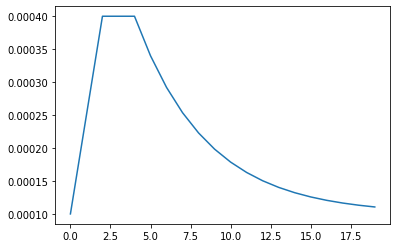

In [8]:
def lrfn(epoch=EPOCHS,
         lr_start=1e-4,
         lr_max=5e-5 * 8, 
         lr_min=1e-4,
         lr_rampup_epochs=2,
         lr_sustain_epochs=2,
         lr_exp_decay=0.8):
    if epoch < lr_rampup_epochs:
        lr = (lr_max-lr_start)/lr_rampup_epochs*epoch + lr_start
    elif epoch < lr_rampup_epochs + lr_sustain_epochs:
        lr = lr_max
    else:
        lr = (lr_max-lr_min)*lr_exp_decay**(epoch-lr_rampup_epochs-lr_sustain_epochs) + lr_min
    return lr

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

y = [lrfn(x) for x in range(EPOCHS)]
plt.plot(y)

### ViTB32

**Text_LSTM**

353255424/353253686 [==============================] - 10s 0us/step


/opt/conda/lib/python3.7/site-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  UserWarning,


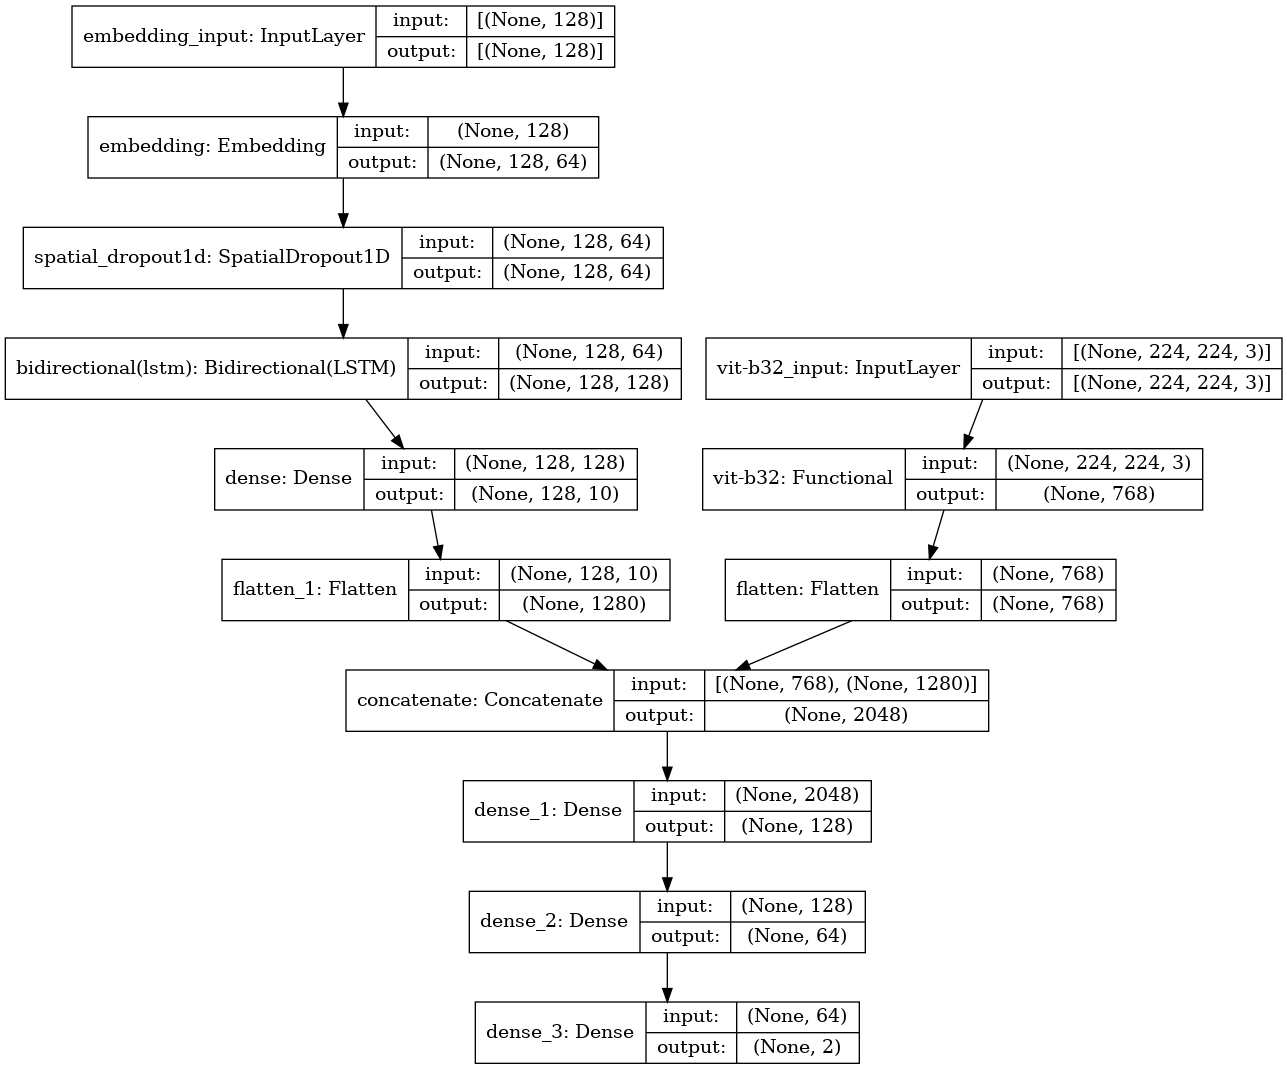

In [9]:
!pip install --quiet vit-keras

from vit_keras import vit
with strategy.scope():
    image_model = Sequential()
    net = vit.vit_b32(
        image_size = (IMG_SIZE, IMG_SIZE),
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False
    )
    image_model.add(net)
    image_model.add(L.Flatten())
    
    
    text_model = Sequential()
    text_model.add(L.Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=64, 
                          input_length=X_train_txt.shape[1]))
    text_model.add(L.SpatialDropout1D(0.4))
    text_model.add(L.Bidirectional(L.LSTM(units=64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
    text_model.add(L.Dense(10, activation='relu'))
    text_model.add(L.Flatten())
    
    combined = L.concatenate([image_model.output, text_model.output])
    z = L.Dense(128, activation="relu")(combined)
    z = L.Dense(64, activation="relu")(z)
    z = L.Dense(2, activation="softmax")(z)
    model = Model(inputs=[image_model.input, text_model.input], outputs=z)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
plot_model(model, show_shapes=True)

In [10]:
    lrs = LearningRateScheduler(lrfn)  
    # tf.config.run_functions_eagerly(True)
    mc = ModelCheckpoint('vit_weights_lstm.h5', save_best_only=True, save_weights_only=True)
    steps_per_epoch = len(y_train) // BATCH_SIZE

    hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, 
                     callbacks=[lrs, mc], validation_data=valid_dataset, verbose=2)

Epoch 1/20


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 171573696 elements. This may consume a large amount of memory.
  num_elements)


902/902 - 2772s - loss: 0.1754 - accuracy: 0.9322 - val_loss: 0.1046 - val_accuracy: 0.9621
Epoch 2/20
902/902 - 88s - loss: 0.0450 - accuracy: 0.9854 - val_loss: 0.1049 - val_accuracy: 0.9667
Epoch 3/20
902/902 - 88s - loss: 0.0150 - accuracy: 0.9956 - val_loss: 0.1527 - val_accuracy: 0.9530
Epoch 4/20
902/902 - 88s - loss: 0.0091 - accuracy: 0.9974 - val_loss: 0.1590 - val_accuracy: 0.9528
Epoch 5/20
902/902 - 88s - loss: 0.0068 - accuracy: 0.9984 - val_loss: 0.1808 - val_accuracy: 0.9510
Epoch 6/20
902/902 - 88s - loss: 0.0049 - accuracy: 0.9989 - val_loss: 0.1829 - val_accuracy: 0.9518
Epoch 7/20
902/902 - 88s - loss: 0.0032 - accuracy: 0.9992 - val_loss: 0.2255 - val_accuracy: 0.9495
Epoch 8/20
902/902 - 88s - loss: 0.0039 - accuracy: 0.9990 - val_loss: 0.1947 - val_accuracy: 0.9530
Epoch 9/20
902/902 - 88s - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.2132 - val_accuracy: 0.9521
Epoch 10/20
902/902 - 88s - loss: 0.0024 - accuracy: 0.9995 - val_loss: 0.1878 - val_accuracy: 0.961

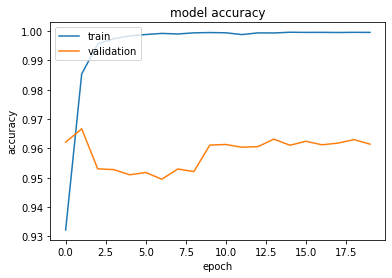

In [11]:
plot_hist(hist)

In [12]:
with strategy.scope():
    model.load_weights('vit_weights_lstm.h5')
y_prob = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 652s 2s/step
              precision    recall  f1-score   support

           0     0.9562    0.9854    0.9706     11546
           1     0.9771    0.9323    0.9542      7701

    accuracy                         0.9642     19247
   macro avg     0.9667    0.9589    0.9624     19247
weighted avg     0.9646    0.9642    0.9641     19247

[[11378   168]
 [  521  7180]]
      TPR       FPR       FNR   ROC AUC
   0.9323    0.0146    0.0677    0.9933


**Text_GRU**

/opt/conda/lib/python3.7/site-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  UserWarning,


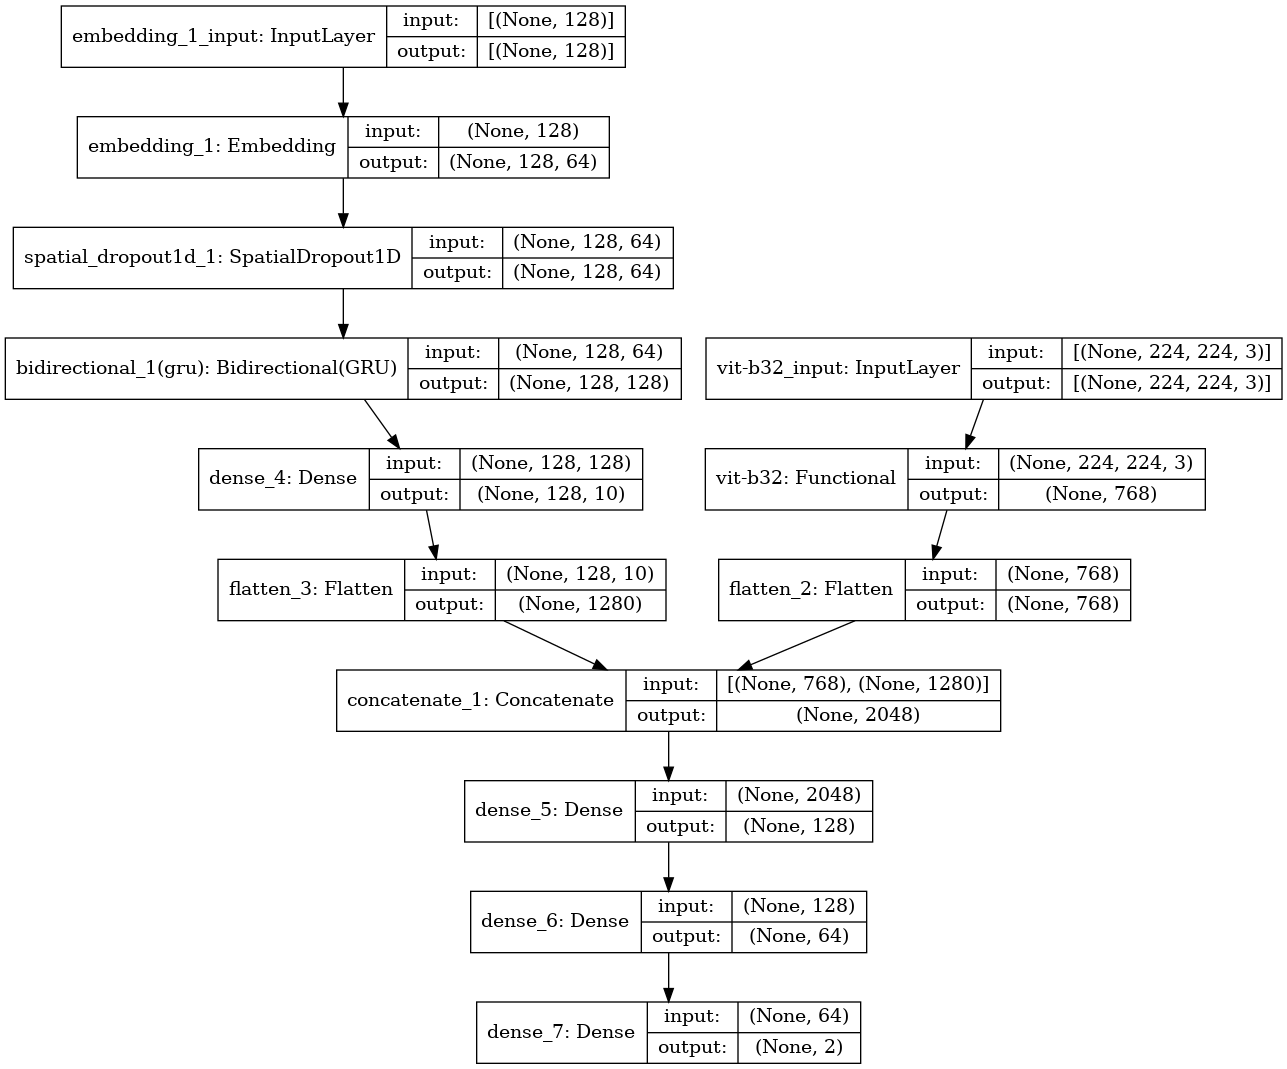

In [13]:
with strategy.scope():
    image_model = Sequential()
    net = vit.vit_b32(
        image_size = (IMG_SIZE, IMG_SIZE),
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False
    )
    image_model.add(net)
    image_model.add(L.Flatten())
    
    
    text_model = Sequential()
    text_model.add(L.Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=64, 
                          input_length=X_train_txt.shape[1]))
    text_model.add(L.SpatialDropout1D(0.4))
    text_model.add(L.Bidirectional(L.GRU(units=64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
    text_model.add(L.Dense(10, activation='relu'))
    text_model.add(L.Flatten())
    
    combined = L.concatenate([image_model.output, text_model.output])
    z = L.Dense(128, activation="relu")(combined)
    z = L.Dense(64, activation="relu")(z)
    z = L.Dense(2, activation="softmax")(z)
    model = Model(inputs=[image_model.input, text_model.input], outputs=z)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
plot_model(model, show_shapes=True)

In [14]:
    lrs = LearningRateScheduler(lrfn)  
    # tf.config.run_functions_eagerly(True)
    mc = ModelCheckpoint('vit_weights_gru.h5', save_best_only=True, save_weights_only=True)
    steps_per_epoch = len(y_train) // BATCH_SIZE

    hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, 
                     callbacks=[lrs, mc], validation_data=valid_dataset, verbose=2)

Epoch 1/20


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 171573696 elements. This may consume a large amount of memory.
  num_elements)


902/902 - 188s - loss: 0.1669 - accuracy: 0.9326 - val_loss: 0.0858 - val_accuracy: 0.9689
Epoch 2/20
902/902 - 88s - loss: 0.0289 - accuracy: 0.9907 - val_loss: 0.1084 - val_accuracy: 0.9693
Epoch 3/20
902/902 - 87s - loss: 0.0087 - accuracy: 0.9976 - val_loss: 0.1226 - val_accuracy: 0.9658
Epoch 4/20
902/902 - 88s - loss: 0.0051 - accuracy: 0.9987 - val_loss: 0.1286 - val_accuracy: 0.9678
Epoch 5/20
902/902 - 88s - loss: 0.0038 - accuracy: 0.9991 - val_loss: 0.1437 - val_accuracy: 0.9688
Epoch 6/20
902/902 - 88s - loss: 0.0029 - accuracy: 0.9993 - val_loss: 0.1660 - val_accuracy: 0.9674
Epoch 7/20
902/902 - 87s - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.1822 - val_accuracy: 0.9667
Epoch 8/20
902/902 - 88s - loss: 0.0021 - accuracy: 0.9994 - val_loss: 0.1885 - val_accuracy: 0.9657
Epoch 9/20
902/902 - 88s - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.2375 - val_accuracy: 0.9664
Epoch 10/20
902/902 - 87s - loss: 0.0020 - accuracy: 0.9994 - val_loss: 0.2147 - val_accuracy: 0.9642

In [15]:
with strategy.scope():
    model.load_weights('vit_weights_gru.h5')
y_prob = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 519s 2s/step
              precision    recall  f1-score   support

           0     0.9680    0.9850    0.9764     11546
           1     0.9769    0.9512    0.9639      7701

    accuracy                         0.9715     19247
   macro avg     0.9725    0.9681    0.9702     19247
weighted avg     0.9716    0.9715    0.9714     19247

[[11373   173]
 [  376  7325]]
      TPR       FPR       FNR   ROC AUC
   0.9512    0.0150    0.0488    0.9952


**Text_CNN**

/opt/conda/lib/python3.7/site-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  UserWarning,


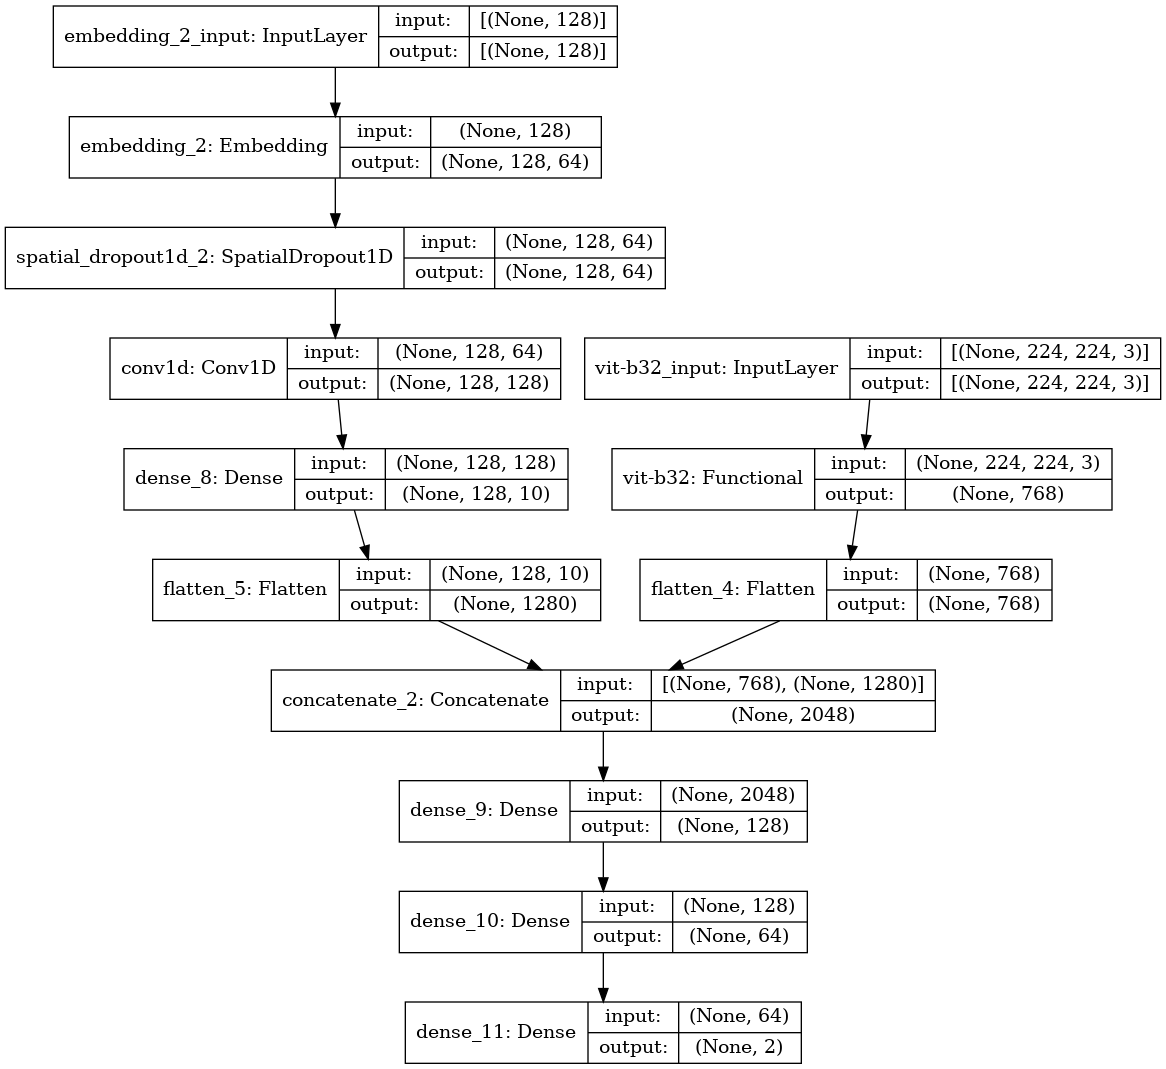

In [16]:
with strategy.scope():
    image_model = Sequential()
    net = vit.vit_b32(
        image_size = (IMG_SIZE, IMG_SIZE),
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False
    )
    image_model.add(net)
    image_model.add(L.Flatten())
    
    
    text_model = Sequential()
    text_model.add(L.Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=64, 
                          input_length=X_train_txt.shape[1]))
    text_model.add(L.SpatialDropout1D(0.4))
    text_model.add(L.Conv1D(128, 5, padding="same",))
    text_model.add(L.Dense(10, activation='relu'))
    text_model.add(L.Flatten())
    
    combined = L.concatenate([image_model.output, text_model.output])
    z = L.Dense(128, activation="relu")(combined)
    z = L.Dense(64, activation="relu")(z)
    z = L.Dense(2, activation="softmax")(z)
    model = Model(inputs=[image_model.input, text_model.input], outputs=z)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
plot_model(model, show_shapes=True)

In [17]:
    lrs = LearningRateScheduler(lrfn)  
    # tf.config.run_functions_eagerly(True)
    mc = ModelCheckpoint('vit_weights_cnn.h5', save_best_only=True, save_weights_only=True)
    steps_per_epoch = len(y_train) // BATCH_SIZE

    hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, 
                     callbacks=[lrs, mc], validation_data=valid_dataset, verbose=2)

Epoch 1/20


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 171573696 elements. This may consume a large amount of memory.
  num_elements)


902/902 - 170s - loss: 0.1779 - accuracy: 0.9270 - val_loss: 0.1028 - val_accuracy: 0.9611
Epoch 2/20
902/902 - 76s - loss: 0.0307 - accuracy: 0.9893 - val_loss: 0.1383 - val_accuracy: 0.9522
Epoch 3/20
902/902 - 76s - loss: 0.0090 - accuracy: 0.9973 - val_loss: 0.1611 - val_accuracy: 0.9512
Epoch 4/20
902/902 - 76s - loss: 0.0048 - accuracy: 0.9987 - val_loss: 0.1786 - val_accuracy: 0.9514
Epoch 5/20
902/902 - 76s - loss: 0.0039 - accuracy: 0.9990 - val_loss: 0.1618 - val_accuracy: 0.9620
Epoch 6/20
902/902 - 76s - loss: 0.0028 - accuracy: 0.9993 - val_loss: 0.1655 - val_accuracy: 0.9497
Epoch 7/20
902/902 - 77s - loss: 0.0021 - accuracy: 0.9994 - val_loss: 0.2161 - val_accuracy: 0.9489
Epoch 8/20
902/902 - 76s - loss: 0.0021 - accuracy: 0.9993 - val_loss: 0.2043 - val_accuracy: 0.9501
Epoch 9/20
902/902 - 76s - loss: 0.0019 - accuracy: 0.9995 - val_loss: 0.1914 - val_accuracy: 0.9498
Epoch 10/20
902/902 - 78s - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.2131 - val_accuracy: 0.9497

In [18]:
with strategy.scope():
    model.load_weights('vit_weights_cnn.h5')
y_prob = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 518s 2s/step
              precision    recall  f1-score   support

           0     0.9520    0.9885    0.9699     11546
           1     0.9817    0.9253    0.9527      7701

    accuracy                         0.9632     19247
   macro avg     0.9669    0.9569    0.9613     19247
weighted avg     0.9639    0.9632    0.9630     19247

[[11413   133]
 [  575  7126]]
      TPR       FPR       FNR   ROC AUC
   0.9253    0.0115    0.0747    0.9937


### VGG19

**Text_LSTM**

80142336/80134624 [==============================] - 0s 0us/step


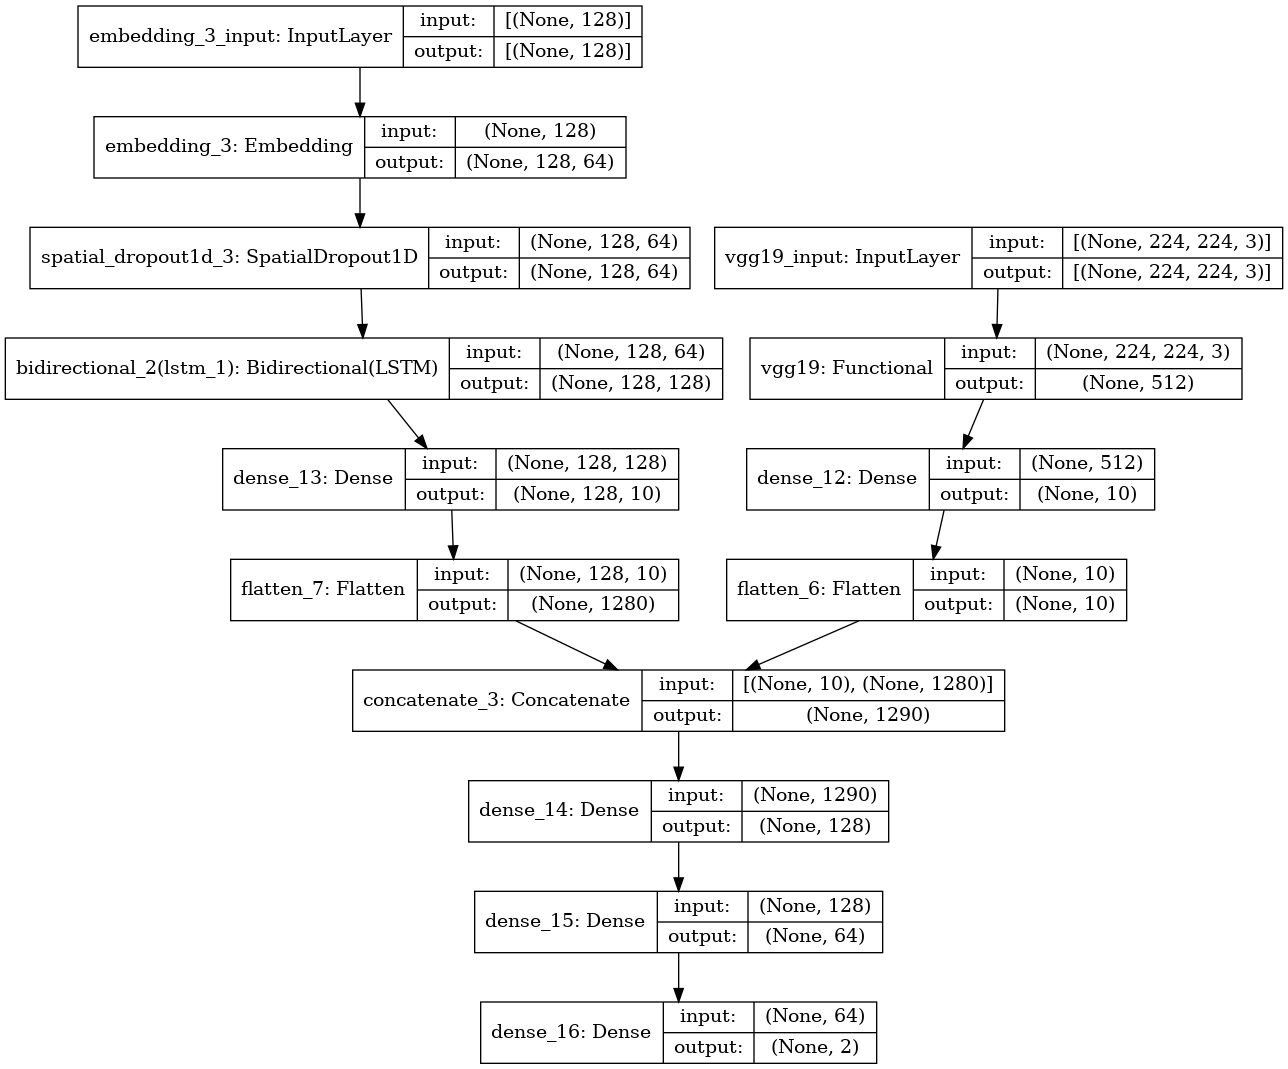

In [19]:
from tensorflow.keras.applications import VGG19
with strategy.scope():
    image_model = Sequential()
    net = VGG19(
        include_top=False, 
        weights='imagenet', 
        pooling='avg', 
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    image_model.add(net)
    image_model.add(L.Dense(10, activation='relu'))
    image_model.add(L.Flatten())
    
    
    text_model = Sequential()
    text_model.add(L.Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=64, 
                          input_length=X_train_txt.shape[1]))
    text_model.add(L.SpatialDropout1D(0.4))
    text_model.add(L.Bidirectional(L.LSTM(units=64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
    text_model.add(L.Dense(10, activation='relu'))
    text_model.add(L.Flatten())
    
    combined = L.concatenate([image_model.output, text_model.output])
    z = L.Dense(128, activation="relu")(combined)
    z = L.Dense(64, activation="relu")(z)
    z = L.Dense(2, activation="softmax")(z)
    model = Model(inputs=[image_model.input, text_model.input], outputs=z)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
plot_model(model, show_shapes=True)

In [20]:
lrs = LearningRateScheduler(lrfn)  
mc = ModelCheckpoint('vgg_weights_lstm.h5', save_best_only=True, save_weights_only=True)
steps_per_epoch = len(y_train) // BATCH_SIZE

hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, 
                 callbacks=[lrs, mc], validation_data=valid_dataset, verbose=2)

Epoch 1/20


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 171573696 elements. This may consume a large amount of memory.
  num_elements)


902/902 - 127s - loss: 0.1706 - accuracy: 0.9279 - val_loss: 0.0944 - val_accuracy: 0.9656
Epoch 2/20
902/902 - 82s - loss: 0.0274 - accuracy: 0.9912 - val_loss: 0.1067 - val_accuracy: 0.9657
Epoch 3/20
902/902 - 82s - loss: 0.0081 - accuracy: 0.9979 - val_loss: 0.1446 - val_accuracy: 0.9538
Epoch 4/20
902/902 - 82s - loss: 0.0055 - accuracy: 0.9986 - val_loss: 0.1377 - val_accuracy: 0.9674
Epoch 5/20
902/902 - 82s - loss: 0.0041 - accuracy: 0.9990 - val_loss: 0.1557 - val_accuracy: 0.9654
Epoch 6/20
902/902 - 81s - loss: 0.0033 - accuracy: 0.9992 - val_loss: 0.1695 - val_accuracy: 0.9663
Epoch 7/20
902/902 - 81s - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.1736 - val_accuracy: 0.9672
Epoch 8/20
902/902 - 82s - loss: 0.0022 - accuracy: 0.9995 - val_loss: 0.1747 - val_accuracy: 0.9652
Epoch 9/20
902/902 - 82s - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.1801 - val_accuracy: 0.9658
Epoch 10/20
902/902 - 82s - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.2348 - val_accuracy: 0.9612

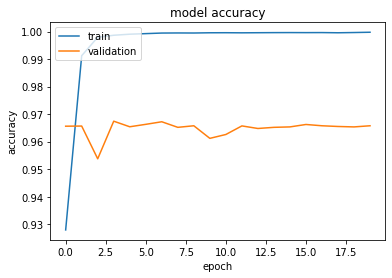

In [21]:
plot_hist(hist)

In [22]:
with strategy.scope():
    model.load_weights('vgg_weights_lstm.h5')
y_prob = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 512s 2s/step
              precision    recall  f1-score   support

           0     0.9631    0.9847    0.9738     11546
           1     0.9762    0.9435    0.9596      7701

    accuracy                         0.9682     19247
   macro avg     0.9697    0.9641    0.9667     19247
weighted avg     0.9684    0.9682    0.9681     19247

[[11369   177]
 [  435  7266]]
      TPR       FPR       FNR   ROC AUC
   0.9435    0.0153    0.0565    0.9945


**Text_GRU**

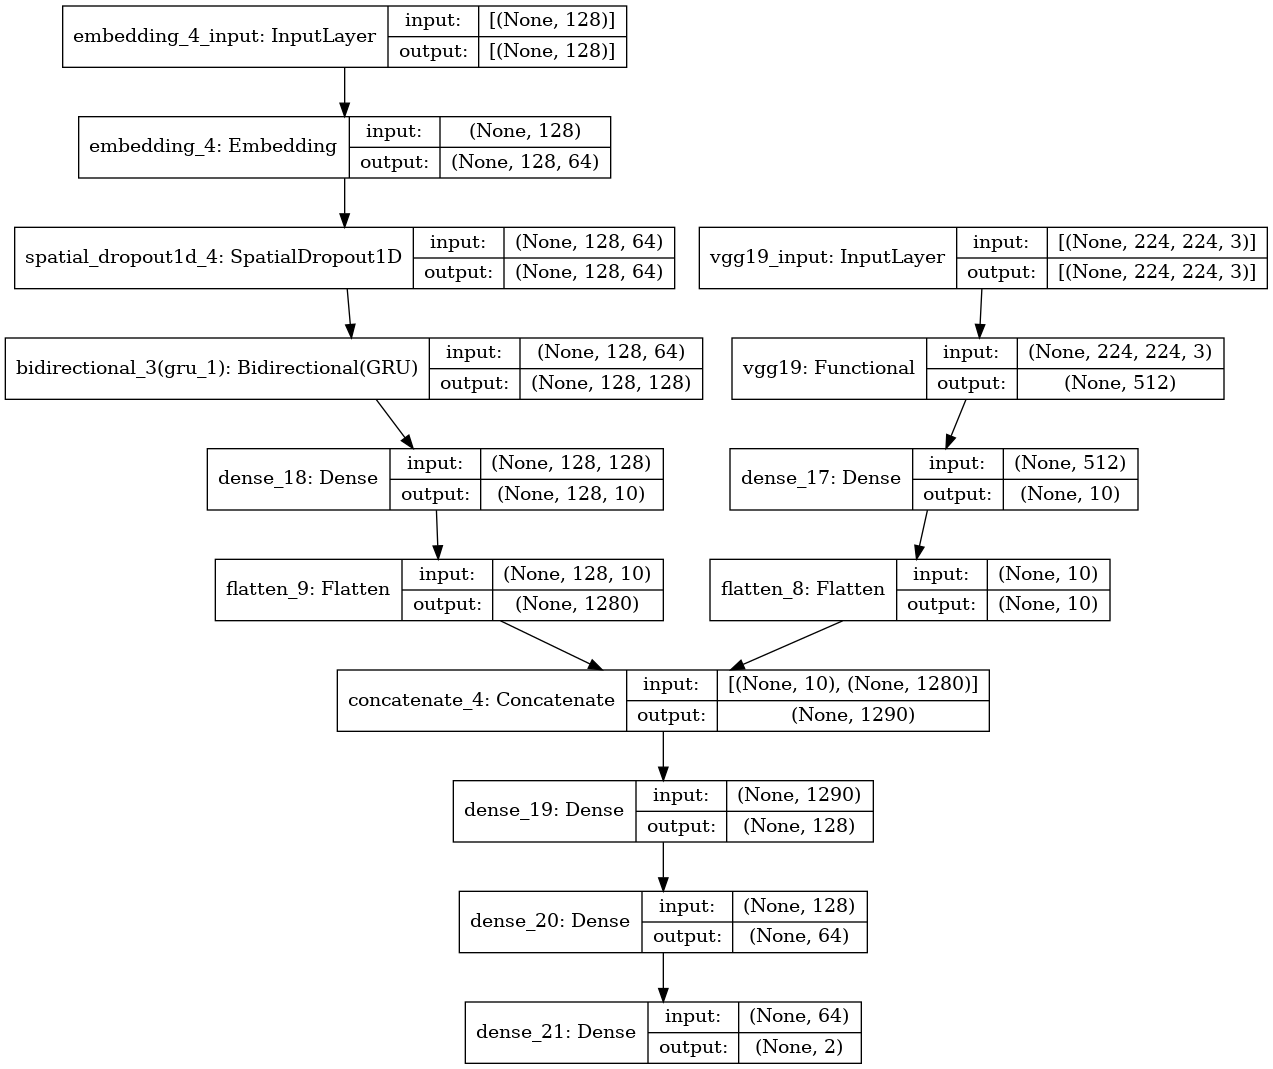

In [23]:
with strategy.scope():
    image_model = Sequential()
    net = VGG19(
        include_top=False, 
        weights='imagenet', 
        pooling='avg', 
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    image_model.add(net)
    image_model.add(L.Dense(10, activation='relu'))
    image_model.add(L.Flatten())
    
    
    text_model = Sequential()
    text_model.add(L.Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=64, 
                          input_length=X_train_txt.shape[1]))
    text_model.add(L.SpatialDropout1D(0.4))
    text_model.add(L.Bidirectional(L.GRU(units=64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
    text_model.add(L.Dense(10, activation='relu'))
    text_model.add(L.Flatten())
    
    combined = L.concatenate([image_model.output, text_model.output])
    z = L.Dense(128, activation="relu")(combined)
    z = L.Dense(64, activation="relu")(z)
    z = L.Dense(2, activation="softmax")(z)
    model = Model(inputs=[image_model.input, text_model.input], outputs=z)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
plot_model(model, show_shapes=True)

In [24]:
lrs = LearningRateScheduler(lrfn)  
mc = ModelCheckpoint('vgg_weights_gru.h5', save_best_only=True, save_weights_only=True)
steps_per_epoch = len(y_train) // BATCH_SIZE

hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, 
                 callbacks=[lrs, mc], validation_data=valid_dataset, verbose=2)

Epoch 1/20


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 171573696 elements. This may consume a large amount of memory.
  num_elements)


902/902 - 123s - loss: 0.1630 - accuracy: 0.9298 - val_loss: 0.0840 - val_accuracy: 0.9690
Epoch 2/20
902/902 - 81s - loss: 0.0262 - accuracy: 0.9913 - val_loss: 0.1221 - val_accuracy: 0.9678
Epoch 3/20
902/902 - 81s - loss: 0.0070 - accuracy: 0.9983 - val_loss: 0.1321 - val_accuracy: 0.9673
Epoch 4/20
902/902 - 81s - loss: 0.0047 - accuracy: 0.9987 - val_loss: 0.1589 - val_accuracy: 0.9644
Epoch 5/20
902/902 - 81s - loss: 0.0036 - accuracy: 0.9991 - val_loss: 0.1587 - val_accuracy: 0.9661
Epoch 6/20
902/902 - 81s - loss: 0.0028 - accuracy: 0.9992 - val_loss: 0.2216 - val_accuracy: 0.9622
Epoch 7/20
902/902 - 82s - loss: 0.0023 - accuracy: 0.9995 - val_loss: 0.2136 - val_accuracy: 0.9651
Epoch 8/20
902/902 - 81s - loss: 0.0022 - accuracy: 0.9995 - val_loss: 0.1982 - val_accuracy: 0.9647
Epoch 9/20
902/902 - 81s - loss: 0.0016 - accuracy: 0.9995 - val_loss: 0.2026 - val_accuracy: 0.9658
Epoch 10/20
902/902 - 82s - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.2225 - val_accuracy: 0.9652

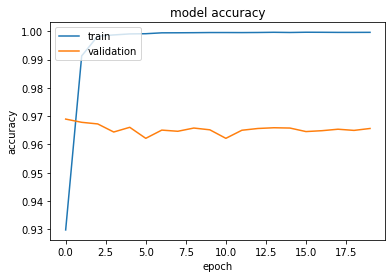

In [25]:
plot_hist(hist)

In [26]:
with strategy.scope():
    model.load_weights('vgg_weights_gru.h5')
y_prob = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 504s 2s/step
              precision    recall  f1-score   support

           0     0.9663    0.9852    0.9756     11546
           1     0.9771    0.9484    0.9626      7701

    accuracy                         0.9705     19247
   macro avg     0.9717    0.9668    0.9691     19247
weighted avg     0.9706    0.9705    0.9704     19247

[[11375   171]
 [  397  7304]]
      TPR       FPR       FNR   ROC AUC
   0.9484    0.0148    0.0516    0.9952


**Text_CNN**

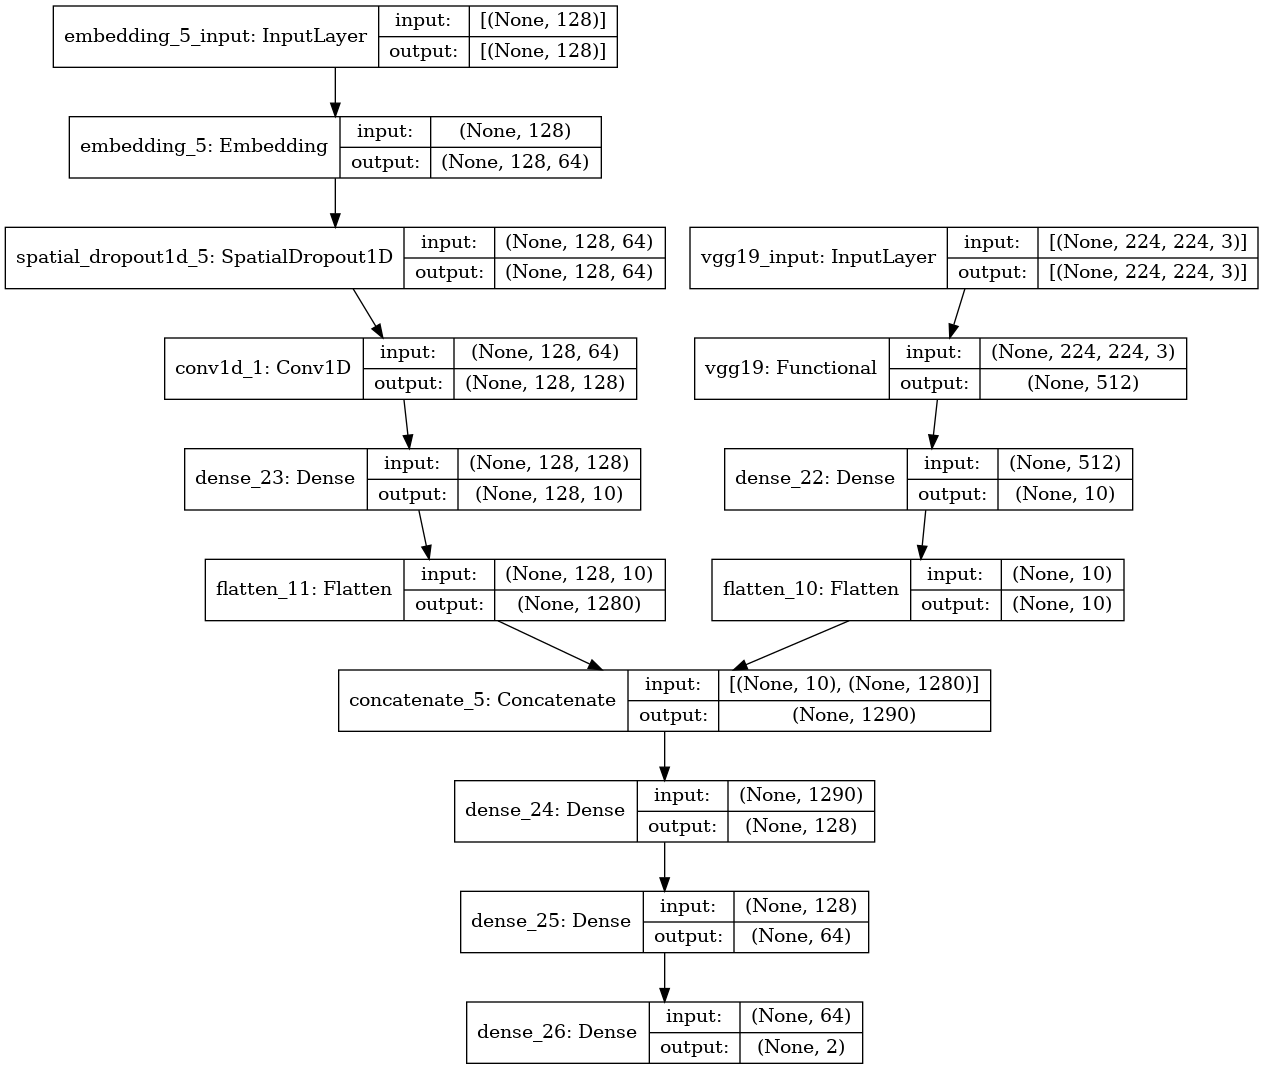

In [27]:
with strategy.scope():
    image_model = Sequential()
    net = VGG19(
        include_top=False, 
        weights='imagenet', 
        pooling='avg', 
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    image_model.add(net)
    image_model.add(L.Dense(10, activation='relu'))
    image_model.add(L.Flatten())
    
    
    text_model = Sequential()
    text_model.add(L.Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=64, 
                          input_length=X_train_txt.shape[1]))
    text_model.add(L.SpatialDropout1D(0.4))
    text_model.add(L.Conv1D(128, 5, padding="same"))
    text_model.add(L.Dense(10, activation='relu'))
    text_model.add(L.Flatten())
    
    combined = L.concatenate([image_model.output, text_model.output])
    z = L.Dense(128, activation="relu")(combined)
    z = L.Dense(64, activation="relu")(z)
    z = L.Dense(2, activation="softmax")(z)
    model = Model(inputs=[image_model.input, text_model.input], outputs=z)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
plot_model(model, show_shapes=True)

In [28]:
lrs = LearningRateScheduler(lrfn)  
mc = ModelCheckpoint('vgg_weights_cnn.h5', save_best_only=True, save_weights_only=True)
steps_per_epoch = len(y_train) // BATCH_SIZE

hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, 
                 callbacks=[lrs, mc], validation_data=valid_dataset, verbose=2)

Epoch 1/20


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 171573696 elements. This may consume a large amount of memory.
  num_elements)


902/902 - 107s - loss: 0.1565 - accuracy: 0.9341 - val_loss: 0.0906 - val_accuracy: 0.9663
Epoch 2/20
902/902 - 74s - loss: 0.0234 - accuracy: 0.9927 - val_loss: 0.1182 - val_accuracy: 0.9669
Epoch 3/20
902/902 - 73s - loss: 0.0059 - accuracy: 0.9984 - val_loss: 0.1427 - val_accuracy: 0.9638
Epoch 4/20
902/902 - 73s - loss: 0.0033 - accuracy: 0.9991 - val_loss: 0.1566 - val_accuracy: 0.9662
Epoch 5/20
902/902 - 74s - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.1699 - val_accuracy: 0.9636
Epoch 6/20
902/902 - 73s - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.1848 - val_accuracy: 0.9659
Epoch 7/20
902/902 - 74s - loss: 0.0016 - accuracy: 0.9995 - val_loss: 0.1887 - val_accuracy: 0.9652
Epoch 8/20
902/902 - 73s - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.1950 - val_accuracy: 0.9663
Epoch 9/20
902/902 - 73s - loss: 0.0014 - accuracy: 0.9995 - val_loss: 0.1937 - val_accuracy: 0.9660
Epoch 10/20
902/902 - 73s - loss: 0.0010 - accuracy: 0.9997 - val_loss: 0.2237 - val_accuracy: 0.9658

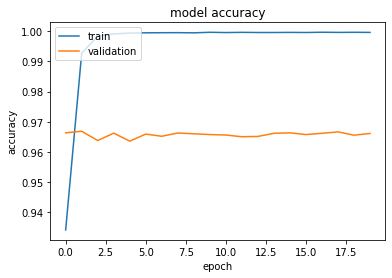

In [29]:
plot_hist(hist)

In [30]:
with strategy.scope():
    model.load_weights('vgg_weights_cnn.h5')
y_prob = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 519s 2s/step
              precision    recall  f1-score   support

           0     0.9616    0.9874    0.9743     11546
           1     0.9802    0.9409    0.9602      7701

    accuracy                         0.9688     19247
   macro avg     0.9709    0.9641    0.9672     19247
weighted avg     0.9691    0.9688    0.9687     19247

[[11400   146]
 [  455  7246]]
      TPR       FPR       FNR   ROC AUC
   0.9409    0.0126    0.0591    0.9947


### DenseNet169

**Text_LSTM**

51879936/51877672 [==============================] - 0s 0us/step


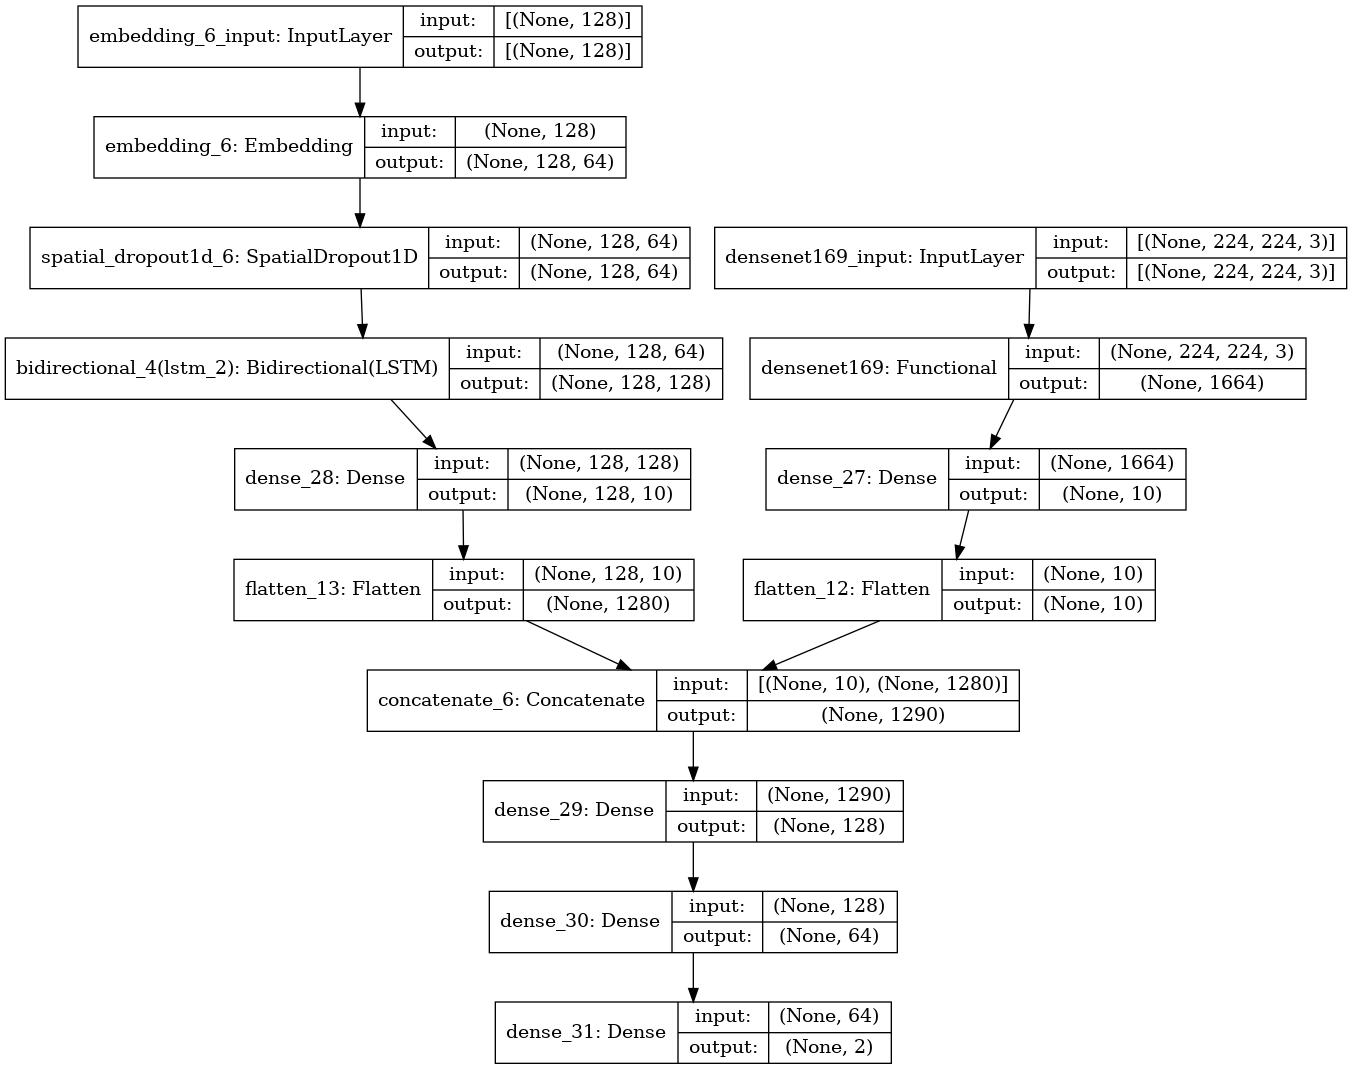

In [31]:
from tensorflow.keras.applications import DenseNet169
with strategy.scope():
    image_model = Sequential()
    net = DenseNet169(
        include_top=False, 
        weights='imagenet', 
        pooling='avg', 
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    image_model.add(net)
    image_model.add(L.Dense(10, activation='relu'))
    image_model.add(L.Flatten())
    
    
    text_model = Sequential()
    text_model.add(L.Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=64, 
                          input_length=X_train_txt.shape[1]))
    text_model.add(L.SpatialDropout1D(0.4))
    text_model.add(L.Bidirectional(L.LSTM(units=64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
    text_model.add(L.Dense(10, activation='relu'))
    text_model.add(L.Flatten())
    
    combined = L.concatenate([image_model.output, text_model.output])
    z = L.Dense(128, activation="relu")(combined)
    z = L.Dense(64, activation="relu")(z)
    z = L.Dense(2, activation="softmax")(z)
    model = Model(inputs=[image_model.input, text_model.input], outputs=z)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
plot_model(model, show_shapes=True)

In [32]:
lrs = LearningRateScheduler(lrfn)  
mc = ModelCheckpoint('dense_weights_lstm.h5', save_best_only=True, save_weights_only=True)
steps_per_epoch = len(y_train) // BATCH_SIZE

hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, 
                 callbacks=[lrs, mc], validation_data=valid_dataset, verbose=2)

Epoch 1/20


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 171573696 elements. This may consume a large amount of memory.
  num_elements)


902/902 - 277s - loss: 0.1457 - accuracy: 0.9426 - val_loss: 0.1037 - val_accuracy: 0.9667
Epoch 2/20
902/902 - 120s - loss: 0.0250 - accuracy: 0.9916 - val_loss: 0.1118 - val_accuracy: 0.9672
Epoch 3/20
902/902 - 121s - loss: 0.0067 - accuracy: 0.9984 - val_loss: 0.1215 - val_accuracy: 0.9666
Epoch 4/20
902/902 - 120s - loss: 0.0043 - accuracy: 0.9990 - val_loss: 0.1242 - val_accuracy: 0.9680
Epoch 5/20
902/902 - 119s - loss: 0.0034 - accuracy: 0.9992 - val_loss: 0.1400 - val_accuracy: 0.9680
Epoch 6/20
902/902 - 120s - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.1534 - val_accuracy: 0.9682
Epoch 7/20
902/902 - 119s - loss: 0.0022 - accuracy: 0.9995 - val_loss: 0.1535 - val_accuracy: 0.9692
Epoch 8/20
902/902 - 119s - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.1561 - val_accuracy: 0.9657
Epoch 9/20
902/902 - 119s - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.1490 - val_accuracy: 0.9688
Epoch 10/20
902/902 - 119s - loss: 0.0014 - accuracy: 0.9995 - val_loss: 0.1815 - val_accurac

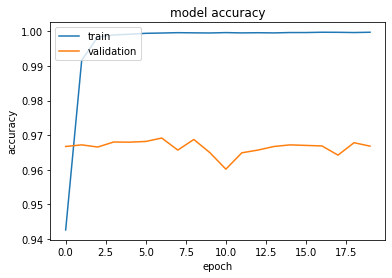

In [33]:
plot_hist(hist)

In [34]:
with strategy.scope():
    model.load_weights('dense_weights_lstm.h5')
y_prob = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 531s 2s/step
              precision    recall  f1-score   support

           0     0.9636    0.9868    0.9751     11546
           1     0.9795    0.9442    0.9615      7701

    accuracy                         0.9698     19247
   macro avg     0.9716    0.9655    0.9683     19247
weighted avg     0.9700    0.9698    0.9697     19247

[[11394   152]
 [  430  7271]]
      TPR       FPR       FNR   ROC AUC
   0.9442    0.0132    0.0558    0.9940


**Text_GRU**

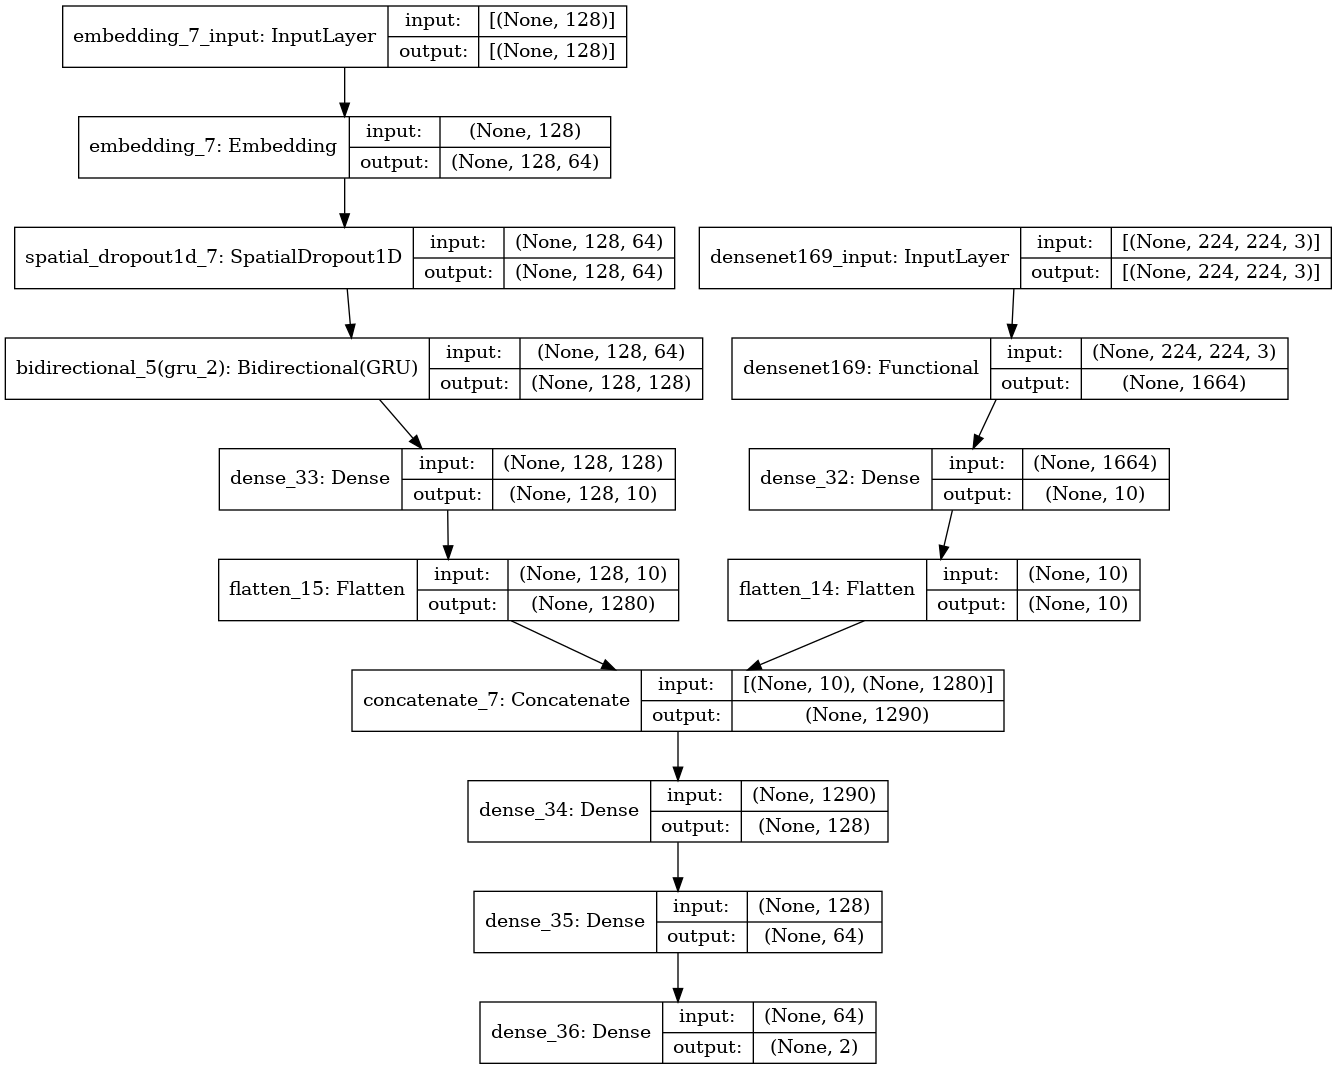

In [35]:
with strategy.scope():
    image_model = Sequential()
    net = DenseNet169(
        include_top=False, 
        weights='imagenet', 
        pooling='avg', 
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    image_model.add(net)
    image_model.add(L.Dense(10, activation='relu'))
    image_model.add(L.Flatten())
    
    
    text_model = Sequential()
    text_model.add(L.Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=64, 
                          input_length=X_train_txt.shape[1]))
    text_model.add(L.SpatialDropout1D(0.4))
    text_model.add(L.Bidirectional(L.GRU(units=64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
    text_model.add(L.Dense(10, activation='relu'))
    text_model.add(L.Flatten())
    
    combined = L.concatenate([image_model.output, text_model.output])
    z = L.Dense(128, activation="relu")(combined)
    z = L.Dense(64, activation="relu")(z)
    z = L.Dense(2, activation="softmax")(z)
    model = Model(inputs=[image_model.input, text_model.input], outputs=z)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
plot_model(model, show_shapes=True)

In [36]:
lrs = LearningRateScheduler(lrfn)  
mc = ModelCheckpoint('dense_weights_gru.h5', save_best_only=True, save_weights_only=True)
steps_per_epoch = len(y_train) // BATCH_SIZE

hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, 
                 callbacks=[lrs, mc], validation_data=valid_dataset, verbose=2)

Epoch 1/20


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 171573696 elements. This may consume a large amount of memory.
  num_elements)


902/902 - 280s - loss: 0.1429 - accuracy: 0.9438 - val_loss: 0.0907 - val_accuracy: 0.9666
Epoch 2/20
902/902 - 118s - loss: 0.0246 - accuracy: 0.9920 - val_loss: 0.1213 - val_accuracy: 0.9650
Epoch 3/20
902/902 - 119s - loss: 0.0075 - accuracy: 0.9980 - val_loss: 0.1311 - val_accuracy: 0.9673
Epoch 4/20
902/902 - 119s - loss: 0.0042 - accuracy: 0.9989 - val_loss: 0.1552 - val_accuracy: 0.9665
Epoch 5/20
902/902 - 119s - loss: 0.0032 - accuracy: 0.9992 - val_loss: 0.1849 - val_accuracy: 0.9660
Epoch 6/20
902/902 - 118s - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.2096 - val_accuracy: 0.9660
Epoch 7/20
902/902 - 119s - loss: 0.0027 - accuracy: 0.9993 - val_loss: 0.1765 - val_accuracy: 0.9654
Epoch 8/20
902/902 - 119s - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.1906 - val_accuracy: 0.9675
Epoch 9/20
902/902 - 119s - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.1968 - val_accuracy: 0.9678
Epoch 10/20
902/902 - 118s - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.2098 - val_accurac

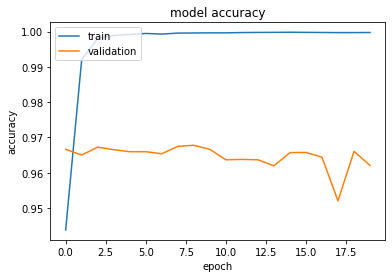

In [37]:
plot_hist(hist)

In [38]:
with strategy.scope():
    model.load_weights('dense_weights_gru.h5')
y_prob = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 501s 2s/step
              precision    recall  f1-score   support

           0     0.9633    0.9853    0.9741     11546
           1     0.9771    0.9436    0.9601      7701

    accuracy                         0.9686     19247
   macro avg     0.9702    0.9645    0.9671     19247
weighted avg     0.9688    0.9686    0.9685     19247

[[11376   170]
 [  434  7267]]
      TPR       FPR       FNR   ROC AUC
   0.9436    0.0147    0.0564    0.9947


**Text_CNN**

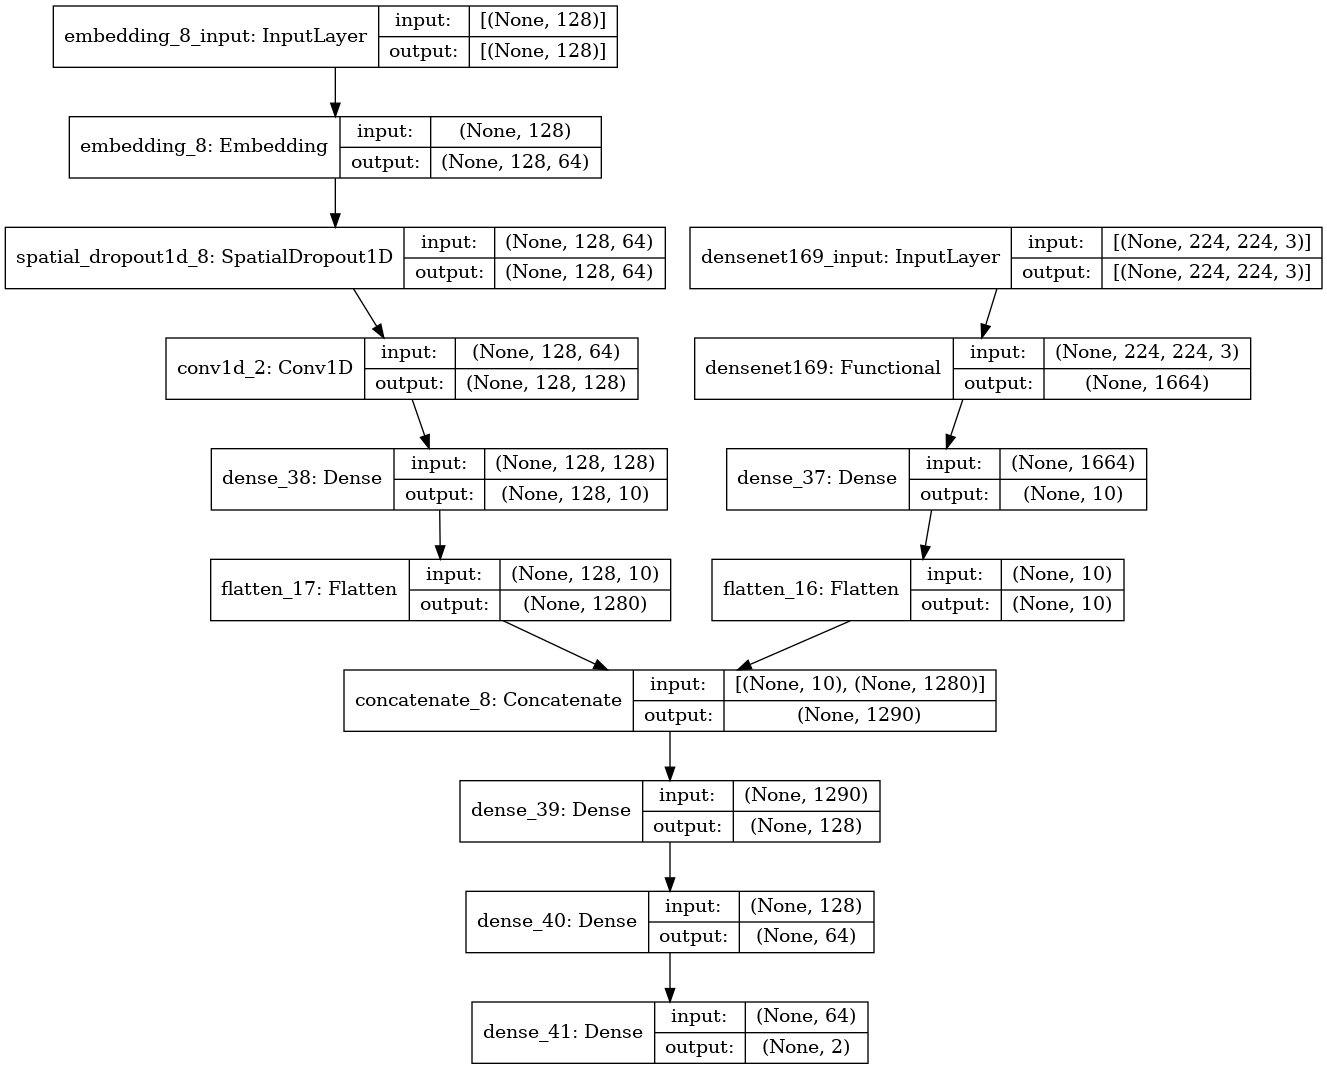

In [39]:
with strategy.scope():
    image_model = Sequential()
    net = DenseNet169(
        include_top=False, 
        weights='imagenet', 
        pooling='avg', 
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    image_model.add(net)
    image_model.add(L.Dense(10, activation='relu'))
    image_model.add(L.Flatten())
    
    
    text_model = Sequential()
    text_model.add(L.Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=64, 
                          input_length=X_train_txt.shape[1]))
    text_model.add(L.SpatialDropout1D(0.4))
    text_model.add(L.Conv1D(128, 5, padding="same"))
    text_model.add(L.Dense(10, activation='relu'))
    text_model.add(L.Flatten())
    
    combined = L.concatenate([image_model.output, text_model.output])
    z = L.Dense(128, activation="relu")(combined)
    z = L.Dense(64, activation="relu")(z)
    z = L.Dense(2, activation="softmax")(z)
    model = Model(inputs=[image_model.input, text_model.input], outputs=z)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
plot_model(model, show_shapes=True)

In [40]:
lrs = LearningRateScheduler(lrfn)  
mc = ModelCheckpoint('dense_weights_cnn.h5', save_best_only=True, save_weights_only=True)
steps_per_epoch = len(y_train) // BATCH_SIZE

hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, 
                 callbacks=[lrs, mc], validation_data=valid_dataset, verbose=2)

Epoch 1/20


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 171573696 elements. This may consume a large amount of memory.
  num_elements)


902/902 - 261s - loss: 0.1393 - accuracy: 0.9459 - val_loss: 0.1266 - val_accuracy: 0.9642
Epoch 2/20
902/902 - 108s - loss: 0.0232 - accuracy: 0.9924 - val_loss: 0.1231 - val_accuracy: 0.9697
Epoch 3/20
902/902 - 109s - loss: 0.0057 - accuracy: 0.9985 - val_loss: 0.1323 - val_accuracy: 0.9680
Epoch 4/20
902/902 - 109s - loss: 0.0036 - accuracy: 0.9992 - val_loss: 0.1528 - val_accuracy: 0.9635
Epoch 5/20
902/902 - 111s - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.1765 - val_accuracy: 0.9689
Epoch 6/20
902/902 - 109s - loss: 0.0019 - accuracy: 0.9995 - val_loss: 0.1885 - val_accuracy: 0.9667
Epoch 7/20
902/902 - 109s - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.2151 - val_accuracy: 0.9679
Epoch 8/20
902/902 - 109s - loss: 0.0014 - accuracy: 0.9995 - val_loss: 0.2096 - val_accuracy: 0.9654
Epoch 9/20
902/902 - 109s - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.2348 - val_accuracy: 0.9674
Epoch 10/20
902/902 - 109s - loss: 8.8007e-04 - accuracy: 0.9997 - val_loss: 0.2349 - val_acc

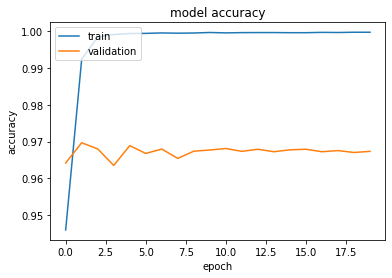

In [41]:
plot_hist(hist)

In [42]:
with strategy.scope():
    model.load_weights('dense_weights_cnn.h5')
y_prob = model.predict(test_dataset, verbose=1)
y_pred = np.argmax(y_prob, axis=1)

clf_report = metrics.classification_report(y_test, y_pred, digits=4)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cnf_matrix.ravel()
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob[:, 1])
auc = metrics.roc_auc_score(y_test, y_prob[:, 1])
other_metrics = pd.DataFrame({'TPR': '%.4f' % TPR, 
                              'FPR': '%.4f' % FPR, 
                              'FNR': '%.4f' % FNR, 
                              'ROC AUC': '%.4f' % auc}, index=[0]).to_string(col_space=9, index=False)
print(clf_report)
print(cnf_matrix)
print(other_metrics)

301/301 [==============================] - 496s 2s/step
              precision    recall  f1-score   support

           0     0.9716    0.9819    0.9767     11546
           1     0.9724    0.9570    0.9647      7701

    accuracy                         0.9719     19247
   macro avg     0.9720    0.9695    0.9707     19247
weighted avg     0.9719    0.9719    0.9719     19247

[[11337   209]
 [  331  7370]]
      TPR       FPR       FNR   ROC AUC
   0.9570    0.0181    0.0430    0.9956
